# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

In [41]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
import numpy as np
import random
from scipy import stats
from scipy.stats import beta
from scipy.special import betaln
#from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML
#import pymc3 as pm
import math
from sklearn.utils import resample
from resample.bootstrap import bootstrap

### Loading Datasets

In [2]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Loading second IGT only data (Reformatted)
IGT_data = pd.read_csv('DRD2_IGT_subset_data.csv', delimiter=',')
IGT_data = IGT_data.dropna(subset=['IGT_scores', 'DRD2'])

### Reformatting Data

In [3]:
# Changing Categorical data to integers
data['DRD2'] = data['DRD2'].astype(int)
data['female_1'] = data['female_1'].astype(int)
IGT_data['DRD2'] = IGT_data['DRD2'].astype(int)

# Changing DRD2 data to category type
data['DRD2_cat'] = pd.cut(data['DRD2'], range(-1,2,1), labels=['Non-Carrier', '-141C Ins/Del Carrier'])
data['DRD2_cat'] = data['DRD2_cat'].astype('object')
IGT_data['DRD2_cat'] = pd.cut(IGT_data['DRD2'], range(-1,2,1), labels=['Non-Carrier', '-141C Ins/Del Carrier'])
IGT_data['DRD2_cat'] = IGT_data['DRD2_cat'].astype('object')

# Splitting data based on DRD2 polymorphism
carrier = data[data['DRD2'] == 1] # Low D2 Receptors
noncarrier = data[data['DRD2'] == 0] # Normal D2 Receptors

## Distribution Plots Version 1

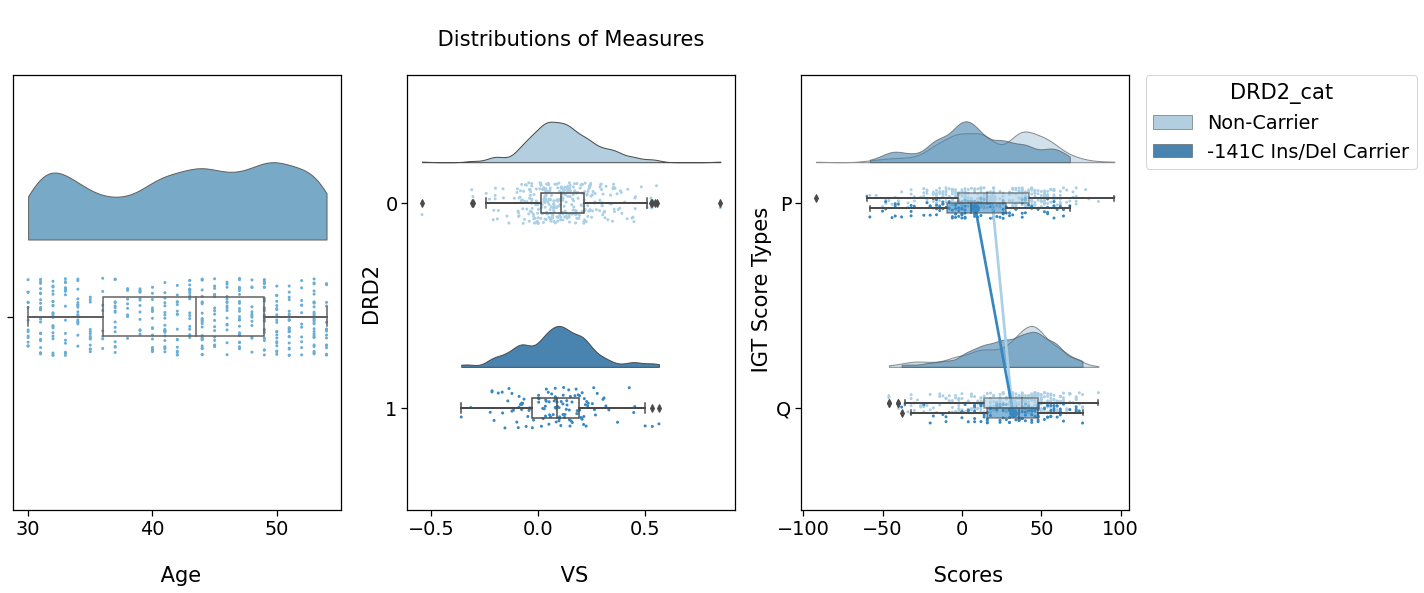

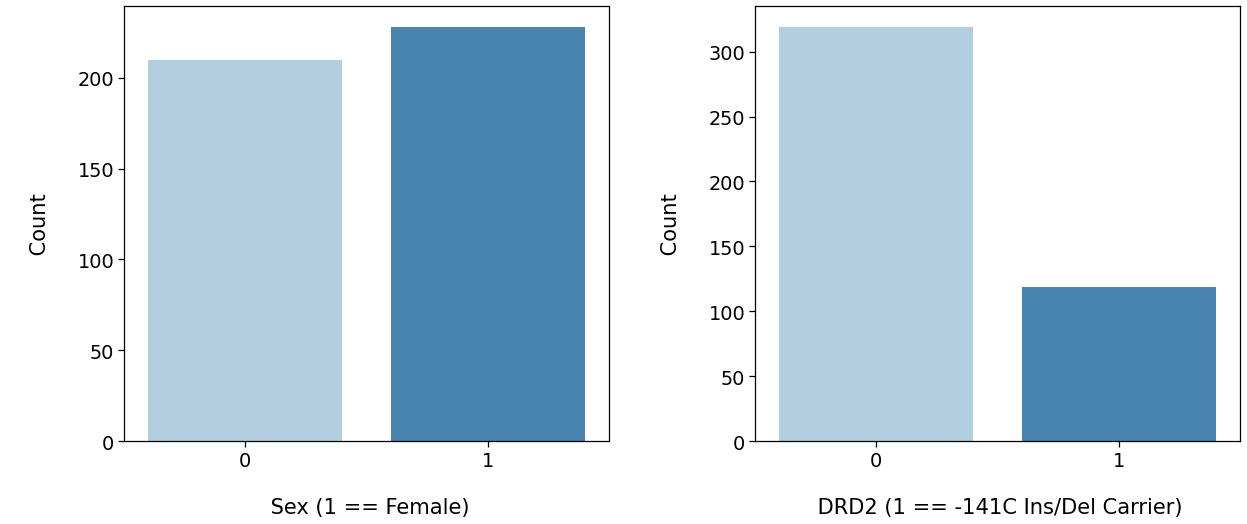

In [90]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.75)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)


# Age Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, 
                   palette="Blues",ax=ax)
age.set(xlabel='\n Age')

# VS Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=data, orient='h', width_viol=.4, width_box=.1, 
                  palette="Blues", ax=ax)
VS.set(xlabel='\n VS', title='\n Distributions of Measures \n')

# IGT Scores Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='IGT_scores', x='IGT_score_type', hue='DRD2_cat', data=IGT_data, orient='h', 
                         width_viol=.4, width_box=.1, palette='Blues', alpha=.6, ax=ax,
                          dodge=True, pointplot=True) #Can comment out if lines aren't helpful
IGT.set(xlabel='\n Scores', ylabel='\n IGT Score Types')

# Configuring 2nd row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.3)
fig.set_figheight(8)
fig.set_figwidth(20)

# Sex Bar Plot
ax = fig.add_subplot(1, 2, 1)
sex = sns.countplot(x="female_1", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n Sex (1 == Female)', ylabel='\n Count \n')

# DRD2 Bar Plot
ax = fig.add_subplot(1, 2, 2)
DRD2 = sns.countplot(x="DRD2", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n DRD2 (1 == -141C Ins/Del Carrier)', ylabel='\n Count \n')

plt.close(3)
plt.close(4)

plt.show()

## Distribution Plots Version 2

<Figure size 432x288 with 0 Axes>

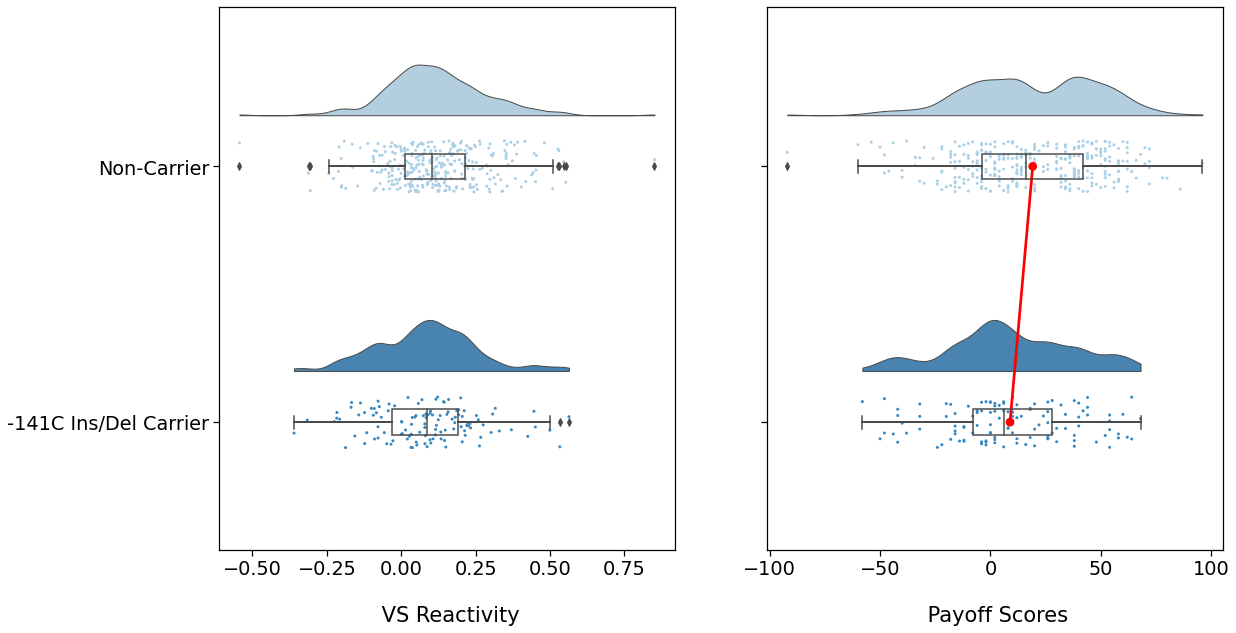

In [92]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.75)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig, axs = plt.subplots(1,2, figsize=(18,10), sharey=True)
axs= axs.ravel()

# VS Rain Cloud Plot
VS = pt.RainCloud(y='VS', x='DRD2_cat', data=data, orient='h', width_viol=.4, width_box=.1, 
                  palette="Blues", ax=axs[0])
VS.set(xlabel='\n VS Reactivity', ylabel='')

# IGT Scores Rain Cloud Plots
IGT = pt.RainCloud(y='P', x='DRD2_cat', data=data, orient='h', width_viol=.4, width_box=.1, 
                   palette='Blues', pointplot=True, ax=axs[1])
IGT.set(xlabel='\n Payoff Scores', ylabel='')
#ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#plt.legend([], ["Attr A", "Attr A+B"])
plt.show()

***


# T-Tests

### T-Test between DRD2 vs P and Q

In [41]:
t_test_results = stats.ttest_ind(carrier.iloc[:,2:5], noncarrier.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)


,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


### Linear Regression Plots

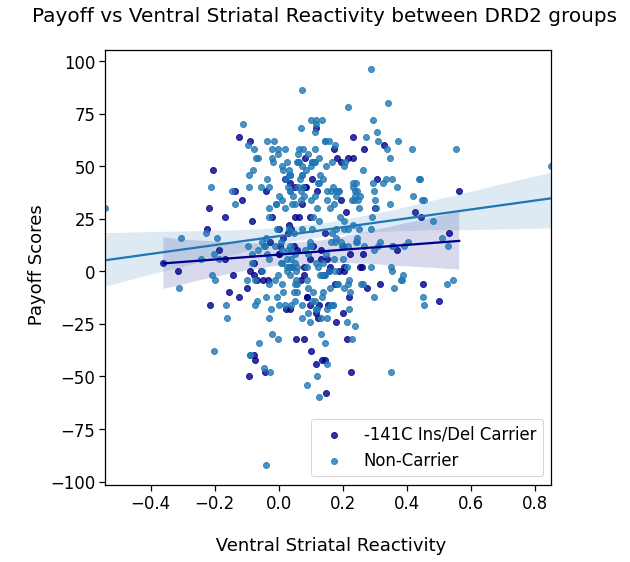

In [87]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring plot
fig = plt.figure(figsize=(8,8))

# P vs VS between DRD2 groups Scatter Plot
scatter_P_low = sns.regplot(x='VS', y='P', data=carrier, label='-141C Ins/Del Carrier', color="darkblue").legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=noncarrier, label='Non-Carrier').legend()
plt.title('Payoff vs Ventral Striatal Reactivity between DRD2 groups \n', fontsize=20)
plt.ylabel('\n Payoff Scores')
plt.xlabel('\n Ventral Striatal Reactivity')

plt.show()

*****


# Linear Regression and Bootstrapped Bayes Factor

## Bootstrap Function

In [36]:
def resample(n):
    return (np.random.randint(low = 0, high = n, size = n))

def my_bootstrap(boot_pop, statistic, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

## P ~ DRD2 + VS + DRD2 * VS + AGE + female_1

In [96]:
results_P_controlled = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS + AGE + female_1', data=data).fit()
HTML(results_P_controlled.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,34.1558,8.292,4.119,0.000,17.858,50.453
DRD2,-9.0558,3.579,-2.530,0.012,-16.090,-2.021
VS,19.6345,9.883,1.987,0.048,0.209,39.060
DRD2:VS,-4.1748,18.595,-0.225,0.822,-40.723,32.373
AGE,-0.2900,0.191,-1.520,0.129,-0.665,0.085
female_1,-9.5413,2.811,-3.394,0.001,-15.067,-4.016


In [97]:
HTML(results_P_controlled.summary().tables[0].as_html())

Dep. Variable:,P,R-squared:,0.068
Model:,OLS,Adj. R-squared:,0.057
Method:,Least Squares,F-statistic:,6.305
Date:,"Thu, 25 Mar 2021",Prob (F-statistic):,1.16e-05
Time:,09:43:20,Log-Likelihood:,-2094.0
No. Observations:,438,AIC:,4200.
Df Residuals:,432,BIC:,4224.
Df Model:,5,,
Covariance Type:,nonrobust,,


## P ~ DRD2 + VS + DRD2 * VS 

In [94]:
results_P_alt = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS', data=data).fit()
HTML(results_P_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


In [95]:
HTML(results_P_alt.summary().tables[0].as_html())

Dep. Variable:,P,R-squared:,0.034
Model:,OLS,Adj. R-squared:,0.028
Method:,Least Squares,F-statistic:,5.162
Date:,"Thu, 25 Mar 2021",Prob (F-statistic):,0.00163
Time:,09:42:52,Log-Likelihood:,-2101.7
No. Observations:,438,AIC:,4211.
Df Residuals:,434,BIC:,4228.
Df Model:,3,,
Covariance Type:,nonrobust,,


## P ~ DRD2 + VS

In [50]:
results_P_null = smf.ols(formula='P ~ DRD2 + VS', data=data).fit()
HTML(results_P_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.0188,1.921,8.858,0.000,13.243,20.795
DRD2,-9.6852,3.176,-3.049,0.002,-15.928,-3.442
VS,18.4295,8.476,2.174,0.030,1.770,35.089


### Bayes Factor for P Models

In [51]:
bayes_factor = math.exp((results_P_alt.bic - results_P_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 18.370166786355266


Strong evidence against the alternative hypothesis (larger BIC value)

## Q ~ DRD2 + VS + DRD2 * VS

In [53]:
results_Q_alt = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_Q_alt.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673


In [54]:
HTML(results_Q_alt.summary().tables[0].as_html())

Dep. Variable:,Q,R-squared:,0.002
Model:,OLS,Adj. R-squared:,-0.005
Method:,Least Squares,F-statistic:,0.2194
Date:,"Tue, 16 Mar 2021",Prob (F-statistic):,0.883
Time:,15:42:25,Log-Likelihood:,-2037.7
No. Observations:,438,AIC:,4083.
Df Residuals:,434,BIC:,4100.
Df Model:,3,,
Covariance Type:,nonrobust,,


## Q ~ DRD2 + VS

In [55]:
results_Q_null = smf.ols(formula='Q ~ DRD2 + VS',data=data).fit()
HTML(results_Q_null.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.7037,1.660,18.499,0.000,27.442,33.966
DRD2,1.6126,2.744,0.588,0.557,-3.781,7.006
VS,4.4126,7.322,0.603,0.547,-9.979,18.804


### Bayes Factor for P Models

In [56]:
bayes_factor = math.exp((results_Q_alt.bic - results_Q_null.bic)/2)
print("Bayes Factor:", bayes_factor)

Bayes Factor: 20.860298419900293


Strong evidence against the alternative hypothesis

***

### Slope Comparison Between Groups

## P ~  VS

#### Ins/Ins Carriers

In [57]:
results_P_carrier = smf.ols(formula='P ~ VS',data=carrier).fit()
HTML(results_P_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.9134,2.939,2.692,0.008,2.092,13.734
VS,11.5671,15.515,0.746,0.457,-19.159,42.293


#### Non-Carriers

In [58]:
results_P_noncarrier = smf.ols(formula='P ~ VS', data=noncarrier).fit()
HTML(results_P_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.040,8.189,0.000,12.691,20.717
VS,21.1400,10.117,2.090,0.037,1.235,41.045


## Q ~  VS

#### Ins/Ins Carriers

In [59]:
results_Q_carrier = smf.ols(formula='Q ~ VS',data=carrier).fit()
HTML(results_Q_carrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.3955,2.426,13.353,0.000,27.591,37.200
VS,3.4748,12.806,0.271,0.787,-21.887,28.837


#### Non-Carriers

In [60]:
results_Q_noncarrier = smf.ols(formula='Q ~ VS',data=noncarrier).fit()
HTML(results_Q_noncarrier.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.789,17.139,0.000,27.141,34.180
VS,4.7830,8.873,0.539,0.590,-12.674,22.240


In [32]:
np.random.seed(123)

def permutationTest(y, diff):
    
    diff_collection = []
    greaterDiff_count = 0
    total = 1500
    sample_size = 438
    
    for i in range(0, total):
        
        # Randomizing DRD2 Assignment
        DRD2_rand = np.random.choice(np.array(data['DRD2']), 438, replace = False)
        VS = np.array(data['VS'])
        y_data = np.array(data[y])
        perm_data = pd.DataFrame({'DRD2_rand':DRD2_rand, 'VS':VS, 'y':y_data})
        
        # Splitting by DRD2 Assignment
        carrier_rand_data = perm_data[perm_data['DRD2_rand'] == 1]
        noncarrier_rand_data = perm_data[perm_data['DRD2_rand'] == 0]
 
        # Carrier Linear Regression
        carrier_rand_res = smf.ols(formula = 'y ~ VS', data=carrier_rand_data).fit()
        carrier_coef = carrier_rand_res.params[1]
        
        # Non-Carrier Linear Regression
        noncarrier_rand_res = smf.ols(formula = 'y ~ VS', data=noncarrier_rand_data).fit()
        noncarrier_coef = noncarrier_rand_res.params[1]
        
        # Calculating Permuted Difference
        rand_diff = noncarrier_coef - carrier_coef
        
        # Collecting Permuted Differences
        diff_collection.append(rand_diff)
        
        # Counting Greater Permuted Differences 
        if rand_diff > diff:
            greaterDiff_count += 1
    
    # Calculating Fraction of Greater Permuted Differences
    PVal  = greaterDiff_count / total
    
    plt.hist(diff_collection, bins=25, edgecolor='k')
    plt.axvline(x=diff, color='black', linestyle='dashed')
    
    return PVal

0.30266666666666664

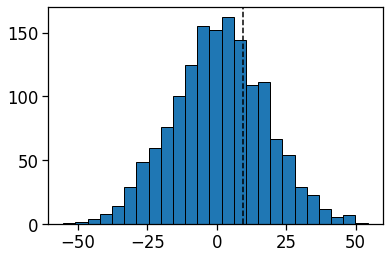

In [33]:
difference = results_P_noncarrier.params[1] - results_P_carrier.params[1]
permutationTest('P', difference)

0.4646666666666667

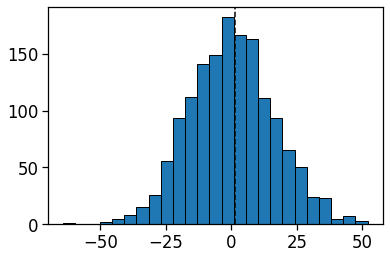

In [34]:
difference = results_Q_noncarrier.params[1] - results_Q_carrier.params[1]
permutationTest('Q', difference)

# VS Quartile Exploration
---

In [6]:
VS_data = data
VS_data.sort_values(by =['VS'], inplace = True)
VS_data['QuantileRank']= pd.qcut(data['VS'], q = 4, labels = False)

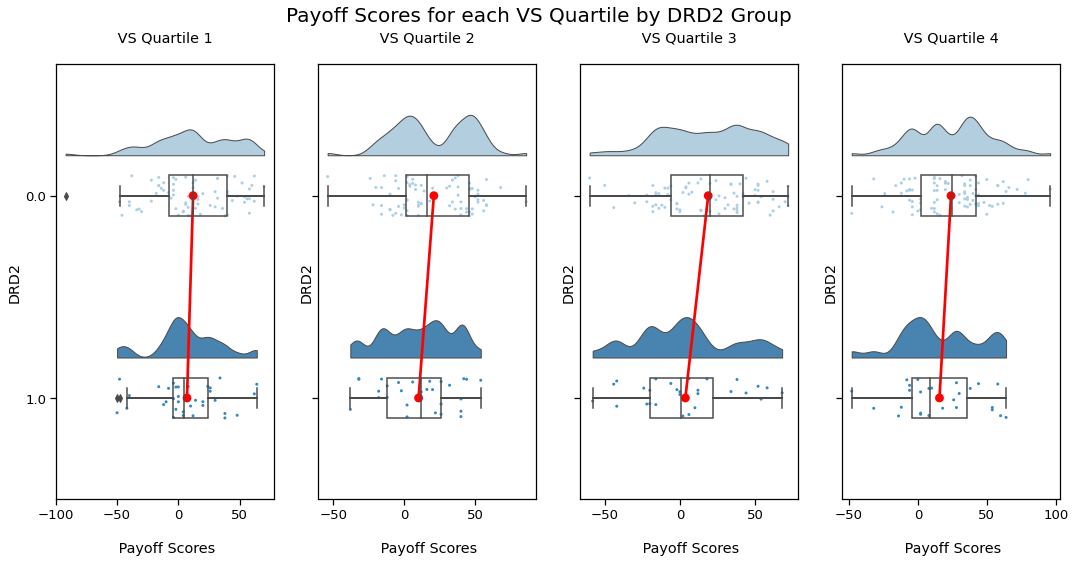

In [110]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots
fig, axs = plt.subplots(1, 4,  figsize=(18,8), sharey=True)

axs = axs.ravel()

fig.suptitle('Payoff Scores for each VS Quartile by DRD2 Group \n', fontsize=20, ha='center')


for i in range(4):
    curr_ax = axs[i]
    VS_curr_data = VS_data[VS_data["QuantileRank"] == i]
    VS = pt.RainCloud(y='P', x='DRD2', orient='h',data=VS_curr_data, width_viol=.4, width_box=.2, 
                   palette='Blues', pointplot=True, ax=curr_ax)
    VS.set(xlabel='\n Payoff Scores')
    VS.set_title(f'\n VS Quartile {i+1} \n')

### VS Tertiles Percentage of Carriers

# Linear Regression Models for VS Tertiles
---

## P ~ DRD2 + VS +  DRD2*VS + AGE + female_1

VS Quartile 1

In [118]:
VS_data_Q1 = VS_data[VS_data["QuantileRank"] == 0]
results_P_VS_Q1 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1', data=VS_data_Q1).fit()
HTML(results_P_VS_Q1.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,29.4209,16.613,1.771,0.080,-3.524,62.365
DRD2,-15.7422,9.211,-1.709,0.090,-34.008,2.524
VS,18.0557,36.950,0.489,0.626,-55.218,91.330
DRD2:VS,-65.5015,67.655,-0.968,0.335,-199.665,68.662
AGE,-0.0235,0.402,-0.058,0.954,-0.821,0.774
female_1,-24.4401,5.953,-4.106,0.000,-36.244,-12.636


In [121]:
results_P_VS_Q1.params["DRD2"]

Intercept    29.420890
DRD2        -15.742160
VS           18.055731
DRD2:VS     -65.501484
AGE          -0.023519
female_1    -24.440055
dtype: float64

VS Quartile 2

In [28]:
VS_data_Q2 = VS_data[VS_data["QuantileRank"] == 1]
results_P_VS_Q2 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q2).fit()
HTML(results_P_VS_Q2.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,25.6535,16.441,1.560,0.122,-6.953,58.260
DRD2,-0.5743,14.221,-0.040,0.968,-28.779,27.630
VS,-81.7551,115.662,-0.707,0.481,-311.143,147.632
DRD2:VS,-135.2193,220.398,-0.614,0.541,-572.327,301.888
AGE,0.1320,0.350,0.378,0.707,-0.561,0.826
female_1,-12.8277,5.059,-2.536,0.013,-22.861,-2.794


VS Quartile 3

In [29]:
VS_data_Q3 = VS_data[VS_data["QuantileRank"] == 2]
results_P_VS_Q3 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q3).fit()
HTML(results_P_VS_Q3.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,92.0947,23.978,3.841,0.000,44.541,139.649
DRD2,-48.1585,34.725,-1.387,0.168,-117.026,20.709
VS,-139.1167,114.685,-1.213,0.228,-366.567,88.333
DRD2:VS,224.7667,228.800,0.982,0.328,-229.004,678.538
AGE,-1.2485,0.383,-3.263,0.001,-2.007,-0.490
female_1,-0.8320,5.974,-0.139,0.890,-12.681,11.016


VS Quartile 4

In [30]:
VS_data_Q4 = VS_data[VS_data["QuantileRank"] == 3]
results_P_VS_Q4 = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS + AGE + female_1',data=VS_data_Q4).fit()
HTML(results_P_VS_Q4.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.3420,19.014,0.334,0.739,-31.362,44.047
DRD2,-15.4428,20.214,-0.764,0.447,-55.527,24.642
VS,5.8227,29.609,0.197,0.844,-52.892,64.538
DRD2:VS,19.7695,60.555,0.326,0.745,-100.314,139.853
AGE,0.3890,0.409,0.952,0.343,-0.421,1.200
female_1,-2.0307,5.490,-0.370,0.712,-12.918,8.857


## Linear Regression Plots for each Quartile by Group

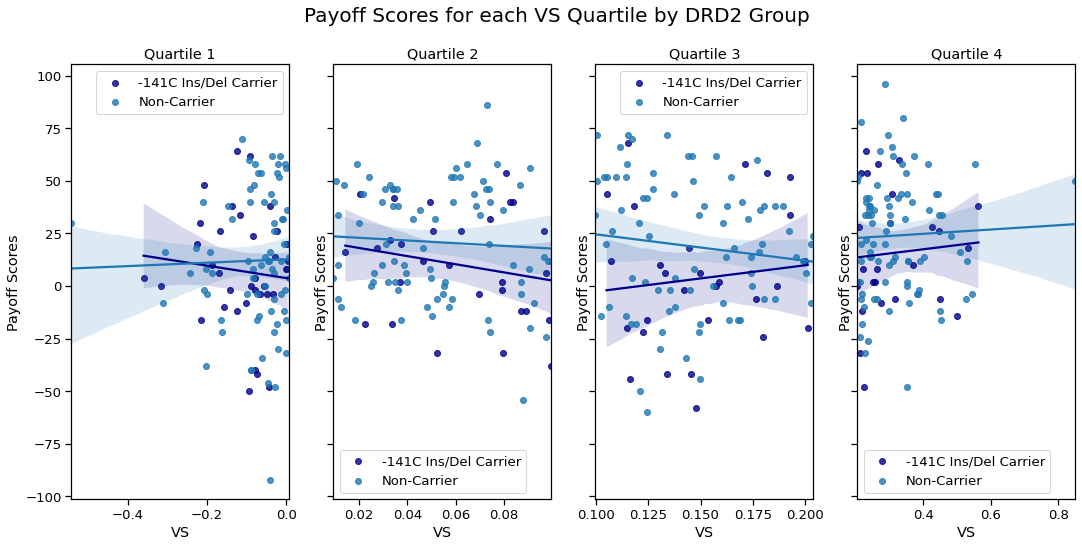

In [34]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.2)

# Configuring 1st row of grid of plots

fig, axs = plt.subplots(1, 4,  figsize=(18,8), sharey=True)

axs = axs.ravel()

fig.suptitle('Payoff Scores for each VS Quartile by DRD2 Group', fontsize=20, ha='center')


for i in range(4):
    curr_ax = axs[i]
    curr_data = VS_data[VS_data["QuantileRank"] == i]
    curr_carrier_data = curr_data[curr_data["DRD2"] == 1]
    curr_noncarrier_data = curr_data[curr_data["DRD2"] == 0]
    
    scatter_P_carrier_1 = sns.regplot(x='VS', y='P', data=curr_carrier_data, label='-141C Ins/Del Carrier', 
                                  color="darkblue", ax=curr_ax).legend()
    scatter_P_noncarrier_1 = sns.regplot(x='VS', y='P', data=curr_noncarrier_data, label='Non-Carrier',
                                        ax=curr_ax).legend()
    curr_ax.set(xlabel='VS')
    curr_ax.set(ylabel='Payoff Scores')
    curr_ax.set_title(f'Quartile {i+1}')


## Bootstrap for DRD2 Coefficients
#### Defining the Bootstrap function for a boostrapped Linear Regression

In [99]:
# Bootstrap function for Bootstrapped data Linear Regression
curr_boot = bootstrap(sample=curr_data[['P', 'VS', 'DRD2']], fn=linreg, size=10000)

def linreg(curr_array):
    
    curr_df = pd.DataFrame(curr_array, columns = ['P', 'VS', 'DRD2'])
    
    results = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS', data=curr_df).fit()

    return results.params["DRD2"]

#### Defining the Bootstrap loop for each VS Quartile

In [57]:
data_coef = {}
data_boot = pd.DataFrame(columns=['Qs','curr_boot'])

for i in range(4):
    curr_data = VS_data[VS_data["QuantileRank"] == i].reset_index()
    
    # DRD2 beta coefficient from Linear Regression calculation
    results = smf.ols(formula='P ~ DRD2 + VS + DRD2*VS', data=curr_data).fit()
    coef = results.params["DRD2"]
    
    data_coef[f'Q{i+1}'] = coef
    
    
    # Bootstrap calculations on mean VS per group
    curr_boot = bootstrap(sample=curr_data[['P', 'VS', 'DRD2']], fn=linreg, size=10000)
    
    for x in range(len(curr_boot)):
        df = pd.DataFrame([[f'Q{i+1}', curr_boot[x]]], columns=['Qs','curr_boot'])
        data_boot = data_boot.append(df)

## Bootstrapped $\beta_{DRD2}$ Coefficient Bar Plot

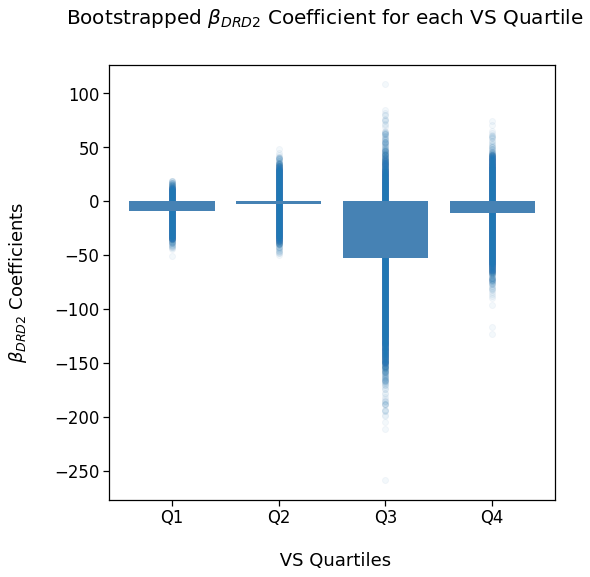

In [88]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

fig = plt.figure(figsize=(8,8))

Qs = list(data_coef.keys())
coefs = list(data_coef.values()) 
plt.scatter('Qs', 'curr_boot', alpha=0.05, data=data_boot, edgecolor="steelblue")
plt.bar(x=Qs, height=coefs, color="steelblue")
fig.suptitle('Bootstrapped $\u03B2_{DRD2}$ Coefficient for each VS Quartile\n', fontsize=20, ha='center')
plt.xlabel(' \n VS Quartiles')
plt.ylabel('$\u03B2_{DRD2}$ Coefficients \n')
plt.show()

---

# <div align="center">Q-Agent on IGT 
    
---

Defines the reinforcement learning Q-Learning Agent on the Iowa Gambling Task and its learning paraments
* r = reward
* RPE = r - Q(s,a)
* 𝛼Gain = Learning Rate when RPE > 0
* 𝛼Loss = Learning Rate when RPE ≤ 0
* 𝜷 = Inverse Temperature (degree of randomness)
* 𝜸 = Reward strength (representative of dopamine reactivity)

In [1]:
from __future__ import division
import numpy as np
from numpy import array
from numpy.random import sample as rs
from numpy import newaxis as na
import pandas as pd
from pandas import DataFrame
from scipy.stats import sem
import seaborn as sns
import string
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import csv
from __future__ import division
from future.utils import listvalues
from scipy.stats.stats import sem
import ptitprince as pt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Update Q (State, Action values)
#### Defines the function that first calculates and updates the Q values of the Q-agent

<div align="center"> If $r - Q(s, a) > 0:$
<div align="center"> $\alpha = \alpha_{Gain}$ 

<div align="center"> Else: 
<div align="center"> $\alpha = \alpha_{Loss}$  

$$Update(Q): Q(s,a) += \alpha(\gamma r + max(Q(s')) - Q(s,a))$$ 
 				
                
$$Update(Q): Q(s,a) += \alpha_{Loss}(\gamma p + max(Q(s')) - Q(s,a))$$ 

In [2]:
def update_Qi(Qval, reward, alpha, gamma):
    """ update q-value of selected action, given reward and alpha
    alpha is changed depending on RPE (reward prediction error)
    (whether (reward - Qval) >= 0, reward gains or (reward - Qval) < 0, reward loss)
    """
    return Qval + (alpha * ((gamma*reward) - Qval))

## P (Selection Probabilities)
#### Defines the function that updates the P values of the Q-Agent

$$Update(P)= \frac {e^{\beta Q_i}}{\sum e^{\beta * (Q_{vector} - max(Q_{vector}))}} $$


* "...where T is a positive parameter called the temperature. High temperatures cause the actions to be all (nearly) equiprobable. Low temperatures cause a greater difference in selection probability for actions that differ in their value estimates."

inverse temperature = beta = greediness
* As temperature increases, beta decreases & greediness DECREASES (explorative)
* As temperature decreases, beta increases & greediness INCREASES (exploitative)

In [3]:
def update_Pall(Qvector, beta):
    """ update vector of action selection probabilities given
    associated q-values
    """ 
    Zvector = Qvector - max(Qvector)
    denom = np.sum(np.exp(beta * Zvector))
        
    resulting_pdata = np.array([np.exp(beta*Q_i) / denom for Q_i in Zvector])
    
    return resulting_pdata

## Iowa Gambling Task 
#### Defines the Iowa Gambling Task (IGT) played by the Q-Agent
#### IGT game design 
100 Trials total (from Bechara, 1997)

|  | Deck A | Deck B | Deck C | Deck D |
| -------- | --- | --- | --- | --- | --- |
| p(gains) | 0.5 | 0.9 | 0.5 | 0.9 |
| g(losses) | 0.5 | 0.1 | 0.5 | 0.1 |
| avg gains | \$100 | \$100 | \$50 | \$50 |
| avg losses | -\$250 | -\$1250 | -\$50 | -\$250 |
| overall gains | -\$75 | -\$75 | \$0 | \$20 |


#### Alternative designs
- switch overall gains of C & D so that C has positive gains and keeps p(gains)=0.5, 
	and D has $0 gains and keeps p(gains)=0.9
	- may be interesting to see the effect of alpha on frequency of gains

In [4]:
class IowaGamblingTask(object):
    """ defines a multi-armed bandit task

    ::Arguments::
        preward (list): 1xN vector of reward probabilities for each of N bandits
        rvalues (list): 1xN vector of payout values for each of N bandits
    """    
            
    def __init__(self):
                
        self.all_cards = pd.read_csv('IGTCards.csv')
        self.deck_gains = self.all_cards.sum()
        self.deck_counters = np.zeros(len(self.all_cards.columns), dtype = int)
        


    def get_feedback(self, action_ix):
    
        if self.deck_counters[action_ix] == 49:
            self.deck_counters[action_ix] = 0
        
        else:    
            self.deck_counters[action_ix] += 1
        
        curr_counter = self.deck_counters[action_ix]
        
        feedback = self.all_cards.iloc[curr_counter, action_ix]
        
        return feedback

## Q-Agent
#### Defines the reinforcement learning Q-Learning Agent on the IGT and its learning paraments

* r = reward
* RPE = r - Q(s,a)
* 𝛼Gain = Learning Rate when RPE > 0
* 𝛼Loss = Learning Rate when RPE ≤ 0
* 𝜷 = Inverse Temperature (degree of randomness)
* 𝜸 = Reward strength (representative of dopamine reactivity)

In [5]:
class Qagent(object):

    """ defines the learning parameters of single q-learning agent
    in the Iowa Gambling Task

    ::Arguments::
        alpha_g (float): learning rate for gains
        alpha_l (float): learning rate for losses
        beta (float): inverse temperature parameter
        gamma (float): sensitivity to reward or losses
        preward (list): 1xN vector of reward probaiblities for each of N decks
        rvalues (list): 1xN vector of payout values for each of N decks
                        IF rvalues is None, all values set to 1
        pvalues (list): 1xN vector of punishment values for each of N decks
                        IF rvalues is None, all values set to 1

    """

    def __init__(self, alpha_g,
                       alpha_l, 
                       beta, 
                       gamma, 
                       decks=['A', 'B', 'C', 'D']):

        if decks is None:
            decks = ['A', 'B', 'C', 'D']

        # calling IowaGamblingTask() function with arguments in Qagent() object
        self.IGT = IowaGamblingTask()
        
        self.alpha_data = []
        
        self.rpe_data = []
        
        # setting parameters passed through Qagent() as arguments
        self.set_params(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma, decks=decks)


    def set_params(self, **kwargs):
        
        """ update parameters of q-learning agent:
                alpha_g = learning rate for gains
                alpha_l = learning rate for losses
                beta = inv. temperature,
                gamma = representative of dopamine release
                epsilon = exploration constant to randomize decisions
                preward = probability of reward, p(reward)
                rvalues = reward amounts  (+$)
                pvalues = punishment amounts (-$)
        """

        kw_keys = list(kwargs)

        if 'alpha_g' in kw_keys:
            self.alpha_g = kwargs['alpha_g']

        if 'alpha_l' in kw_keys:
            self.alpha_l = kwargs['alpha_l']

        if 'beta' in kw_keys:
            self.beta = kwargs['beta']

        if 'gamma' in kw_keys:
            self.gamma = kwargs['gamma']
        
        if 'decks' in kw_keys:
            self.decks = kwargs['decks']

        # number of choices/options
        self.nact = len(self.decks)

        # actions limited to number of choices/options
        self.actions = np.arange(self.nact)


    def play_IGT(self, ntrials=100, get_output=True):
        
        """ simulates agent performance on a multi-armed bandit task

        ::Arguments::
            ntrials (int): number of trials to play bandits
            get_output (bool): returns output DF if True (default)

        ::Returns::
            DataFrame (Ntrials x Nbandits) with trialwise Q and P
            values for each bandit
        """
        
        pdata = np.zeros((ntrials + 1, self.nact))
        
        pdata[0, :] = np.array([1/self.nact]*self.nact)
        
        qdata = np.zeros_like(pdata)
        self.choices = []
        self.feedback = []

        for t in range(ntrials):

            # select bandit arm (action)            
            act_i = np.random.choice(self.actions, p=pdata[t, :])
            
            # observe feedback
            r = self.IGT.get_feedback(act_i)

            # update value of selected action depending on whether it is a gain or loss
            rpe = r - qdata[t, act_i]
            if rpe >= 0:
                alpha = self.alpha_g
            if rpe < 0:
                alpha = self.alpha_l
            
            qdata[t+1, act_i] = update_Qi(qdata[t, act_i], r, alpha, self.gamma)

            # broadcast old q-values for unchosen actions
            for act_j in self.actions[np.where(self.actions!=act_i)]:
                qdata[t+1, act_j] = qdata[t, act_j]

            # update action selection probabilities and store data
            pdata[t+1, :] = update_Pall(qdata[t+1, :], self.beta)
            
            self.choices.append(act_i)
            self.feedback.append(r)
            self.rpe_data.append(rpe)
            self.alpha_data.append(alpha)
        
        self.pdata = pdata[1:, :]
        self.qdata = qdata[1:, :]
        self.make_output_df()

        if get_output:
            return self.data.copy()


    def make_output_df(self):
        """ generate output dataframe with trialwise Q and P measures for each bandit,
        as well as choice selection, and feedback
        """
        df = pd.concat([pd.DataFrame(dat) for dat in [self.qdata, self.pdata]], axis=1)
        columns = np.hstack(([['{}{}'.format(x, c) for c in self.actions] for x in ['q', 'p']]))
        df.columns = columns
        df.insert(0, 'trial', np.arange(1, df.shape[0]+1))
        df['choice'] = self.choices
        df['feedback'] = self.feedback
        
        # replace 3 with self.IGT.deck_gains.values.argmax()
        df['optimal'] = np.where(df['choice']==2, 1, 0)
        df['RPE'] = self.rpe_data
        df['alpha'] = self.alpha_data
        df.insert(0, 'agent', 1)
        self.data = df.copy()


    def simulate_multiple(self, nsims=10, ntrials=1000):
        """ simulates multiple identical agents on multi-armed bandit task
        """
        dflist = []
        for i in range(nsims):
            data_i = self.play_IGT(ntrials=ntrials, get_output=True)
            data_i['agent'] += i
            dflist.append(data_i)
        return pd.concat(dflist)

## Q-Agent Trial Analysis

In [6]:
def get_optimal_auc(df, nblocks=25, verbose=False, as_percent=True):
    xdf = blockify_trials(df, nblocks=nblocks)
    muOptDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    auc = pd.pivot_table(muOptDF, values='optimal', index='block').values.sum()
    if as_percent:
        auc = (auc / nblocks) * 100
        print("Optimal Choice (Deck 3) chosen {:.2f}% of time".format(auc))
    if verbose:
        print("Optimal Choice (Deck 3) chosen {:.2f} times".format(auc))

    return auc

def analyze_bandits(df, nblocks=25, get_err=False):
    xdf = blockify_trials(df, nblocks=nblocks)
    optDF = xdf.groupby(['agent', 'block']).mean().reset_index()
    muOpt = pd.pivot_table(optDF, values='optimal', index='block').values
    muOpt = np.hstack(muOpt)
    if get_err:
        errOpt = pd.pivot_table(optDF, values='optimal', index='block', aggfunc=sem).values*1.96
        errOpt = np.hstack(errOpt)
    else:
        errOpt = np.zeros_like(muOpt)
    return muOpt, errOpt

def blockify_trials(data, nblocks=5, conds=None, groups=['agent']):

    datadf = data.copy()
    if conds is not None:
        if type(conds) is str:
            conds = [conds]
        groups = groups + conds

    idxdflist = []
    for dfinfo, idxdf in datadf.groupby(groups):
        ixblocks = np.array_split(idxdf.trial.values, nblocks)
        blocks = np.hstack([[i+1]*arr.size for i, arr in enumerate(ixblocks)])
        idxdf = idxdf.copy()
        colname = 'block'
        idxdf[colname] = blocks
        idxdflist.append(idxdf)

    return pd.concat(idxdflist)


## Q-Agent Trial IGT Scores Calculation 
* Payoff
* Sensitivity to Frequency of Rewards

In [7]:
def get_IGT_scores(data):
    
    # initializing a choice dictionary with the default of 0 times chosen
    choice_dict = {0: 0, 1:0, 2:0, 3:0}
    
    # updating the choice dictionary with the deck choices made
    choices_made = data['choice'].value_counts(sort = False).to_dict()
    
    for key, value in choices_made.items():
        choice_dict[key] = value

    A, B, C, D = choice_dict.get(0), choice_dict.get(1), choice_dict.get(2), choice_dict.get(3)
    
    # Payoff (P)
    payoff = (C + D) - (A + B)
    
    # Sensitivity to frequency of gains (Q)
    sensitivity = (B + D) - (A + C)
    
    return pd.Series((payoff, sensitivity))

## Q-Agent Trial Run Plots
* Choice Raster Plot
* Q(Decks) Line Plot
* P(Decks) Line Plot
* % Optimal Deck (C) Chosen Line Area Plot

In [8]:
def plot_qlearning(data, nblocks=25, analyze=True):

    if analyze:
        auc = get_optimal_auc(data, nblocks, as_percent=True)

    sns.set(style='white', font_scale=1.3)
    clrs = ['#3778bf', '#feb308', '#9b59b6', '#2ecc71', '#e74c3c',
            '#3498db', '#fd7f23', '#694098', '#319455', '#f266db',
            '#13579d', '#fa8d67'  '#a38ff1'  '#3caca4', '#c24f54']

    f, ([[ax0, ax1], [ax2, ax3]]) = plt.subplots(2, 2, figsize=(15,10))
    df = data.copy()
    nactions = int(df.columns[-6].split('p')[-1])+1
    actions = np.arange(nactions)

    mudf = df.groupby('trial').mean().reset_index()
    errdf = df.groupby('trial').sem().reset_index()*1.96
    x = mudf.trial.values
    

    plot_err = True
    if np.isnan(errdf.loc[1, 'q0']):
        plot_err = False

    x3 = np.arange(1, nblocks+1)
    chance = 1/nactions
    mu3, err3 = analyze_bandits(df, nblocks=nblocks, get_err=plot_err)
    ax3.plot(x3, mu3, color='k')
    ax3.hlines(chance, 1, x3[-1], color='k', linestyles='--', label='chance')
    

    for i, act in enumerate(actions):
        muQ = mudf['q{}'.format(act)].values
        muP = mudf['p{}'.format(act)].values

        choices = [data[data["choice"] == i]["trial"].values]
        ax0.eventplot(positions=choices, lineoffsets=[i+1], 
                      orientation='horizontal', color=clrs[i])
        letters = ["A", "B", "C", "D"]
        ax1.plot(x, muQ, label='$deck_{}$'.format(letters[i]), color=clrs[i])
        ax2.plot(x, muP, color=clrs[i])

        
        
        if plot_err:
            errQ = errdf['q{}'.format(act)].values
            errP = errdf['p{}'.format(act)].values
            ax1.fill_between(x, muQ-errQ, muQ+errQ, color=clrs[i], alpha=.2)
            ax2.fill_between(x, muP-errP, muP+errP, color=clrs[i], alpha=.2)
            if i==0:
                ax3.fill_between(x3, mu3-err3, mu3+err3, color='k', alpha=.15)
        else:
            ychance = np.ones(mu3.size) * chance
            mu3A = np.copy(mu3)
            mu3B = np.copy(mu3)
            mu3A[np.where(mu3<=chance)] = chance
            mu3B[np.where(mu3>=chance)] = chance
            ax3.fill_between(x3, ychance, mu3A, color='#2ecc71', alpha=.15)
            ax3.fill_between(x3, ychance, mu3B, color='#e74c3c', alpha=.15)

    ax0.set_yticks([1,2,3,4], minor=False)
    ax0.set_yticklabels(["A", "B", "C", "D"], fontdict=None, minor=False)
    ax0.set_ylabel('Deck Choices')

    
    #ax1.legend(bbox_to_anchor=(-1.5,0.3), loc="lower right")
    ax1.set_ylabel('$Q(Deck)$')
    ax1.set_title('Value')

    ax2.set_ylabel('$P(Deck)$')
    ax2.set_ylim(0,1)
    ax2.set_title('Softmax Prob.')

    ax3.set_ylim(0,1)
    ax3.set_ylabel('% Optimal Deck C')
    ax3.set_xticks([1, nblocks+1])
    ax3.set_xticklabels([1, df.trial.max()])
    ax3.legend(loc="upper right")

    for ax in f.axes:
        ax.set_xlabel('Trials')
    plt.tight_layout()
    sns.despine()


## Q-Agent Trial Run
Example
* alpha gain = 1.5
* alpha loss = 1.4
* beta = 0.006
* gamma = 1

Optimal Choice (Deck 3) chosen 55.00% of time


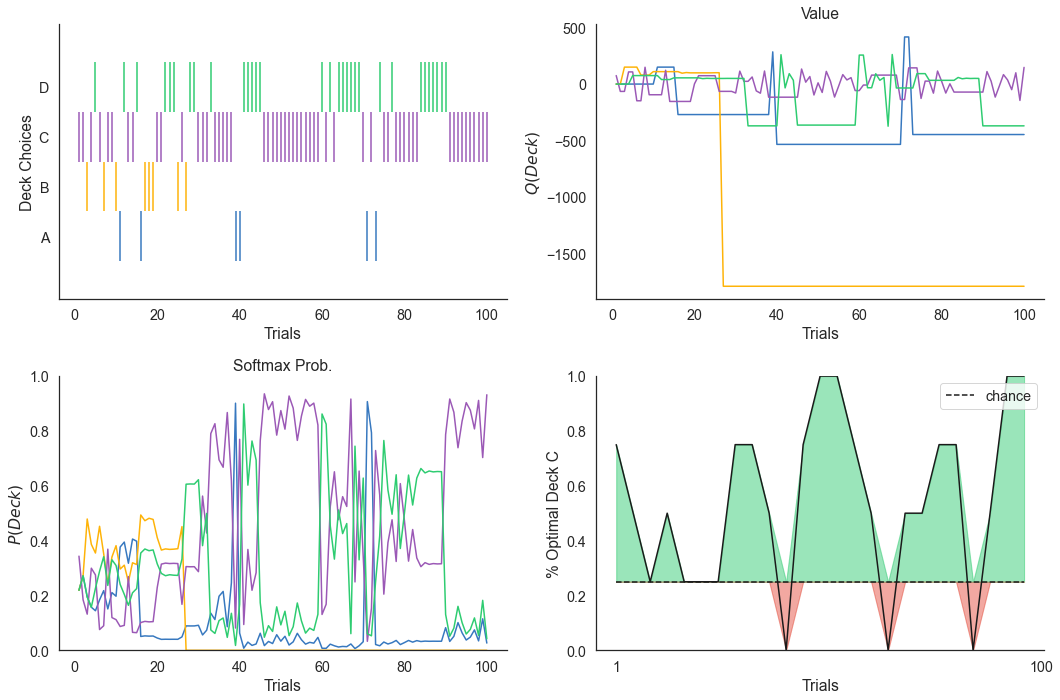

In [10]:
# Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma)
agent = Qagent(alpha_g=1.5, alpha_l=1.4, beta=0.006, gamma=1)

# play 800 trials of multi-armed bandit task
data = agent.play_IGT(ntrials=100, get_output=True)

# plot Q-values and softmax selection prob. for each bandit
plot_qlearning(data)

In [11]:
def plot_heatmaps(data):
    
    plt.figure(figsize=(14, 11))
    heatmap_df = pd.pivot(data, index = "Alpha Loss", columns = "Alpha Gain", values = "Payoff").astype('float')
    
    
    sns.heatmap(heatmap_df, square = True, cmap='RdBu_r', vmin=-100, vmax=100).invert_yaxis()
    plt.plot([0, 20], [0, 20])

In [12]:
def agent_df(agmax, almax, astep, given_beta, given_gamma):
    df_columns = np.array(['Alpha Gain', 'Alpha Loss', 'Beta', 'Gamma', 'Payoff', 'Sensitivity'])
    df = pd.DataFrame(dtype=float, columns=df_columns)
    
    for cycle in np.arange(0, 50, 1): 
        
        #alpha gains should only be positive, 0 to 1 for example
        for alpha_g in np.arange(0, agmax, astep):

            #alpha loss should only be positive, 0 to 1 for example
            for alpha_l in np.arange(0, almax, astep):

                beta = given_beta
                gamma = given_gamma
                alpha_g, alpha_l, beta = np.round(alpha_g, 1), np.round(alpha_l, 3), np.round(beta, 3)
                agent = Qagent(alpha_g=alpha_g, alpha_l=alpha_l, beta=beta, gamma=gamma)
                data = agent.play_IGT(ntrials=100, get_output=True)
                scores = get_IGT_scores(data)
                payoff, sensitivity = scores.iloc[0], scores.iloc[1]
                trial_df = pd.DataFrame([[alpha_g, alpha_l, beta, gamma, payoff, sensitivity]], columns = df_columns)
                df = df.append(trial_df)
                df.reset_index(drop=True, inplace=True)

    return df

#### Q-Agent Perfomance Parameter Analysis for the following ranges:
* $\beta$ = 0.003 - 0.006
* $\alpha_{Gains}$ = 0 - 2
* $\alpha_{Loss}$ = 0 - 2
* $\gamma$ = 0.5, 1, 2

In [14]:
# agent_df(agmax, almax, astep, given_beta, given_gamma)
mydf1 = agent_df(2, 2, .1, .003, 0.5)
mydf2 = agent_df(2, 2, .1, .003, 1)
mydf3 = agent_df(2, 2, .1, .003, 1)
mydf4 = agent_df(2, 2, .1, .006, 0.5)
mydf5 = agent_df(2, 2, .1, .006, 1)
mydf6 = agent_df(2, 2, .1, .006, 2)

In [15]:
# Saving Q-Agent data for Parameter analysis in a List of Q-Agent Dataframes
mydfs_dup = [mydf1, mydf2, mydf3, mydf4, mydf5, mydf6]
mydfs = []

for df in mydfs_dup:
    df = df.groupby(['Alpha Gain', 'Alpha Loss'])[['Beta', 'Gamma','Payoff']].mean().reset_index()
    mydfs.append(df)

## Heat Maps
### Defines Heat Maps of Payoff Scores for $\alpha_{Gains}$ and $\alpha_{Loss}$ with Parameter Analysis Q-Agents
* $\beta$ = 0.003 - 0.006
* $\alpha_{Gains}$ = 0 - 2
* $\alpha_{Loss}$ = 0 - 2
* $\gamma$ = 0.5, 1, 2

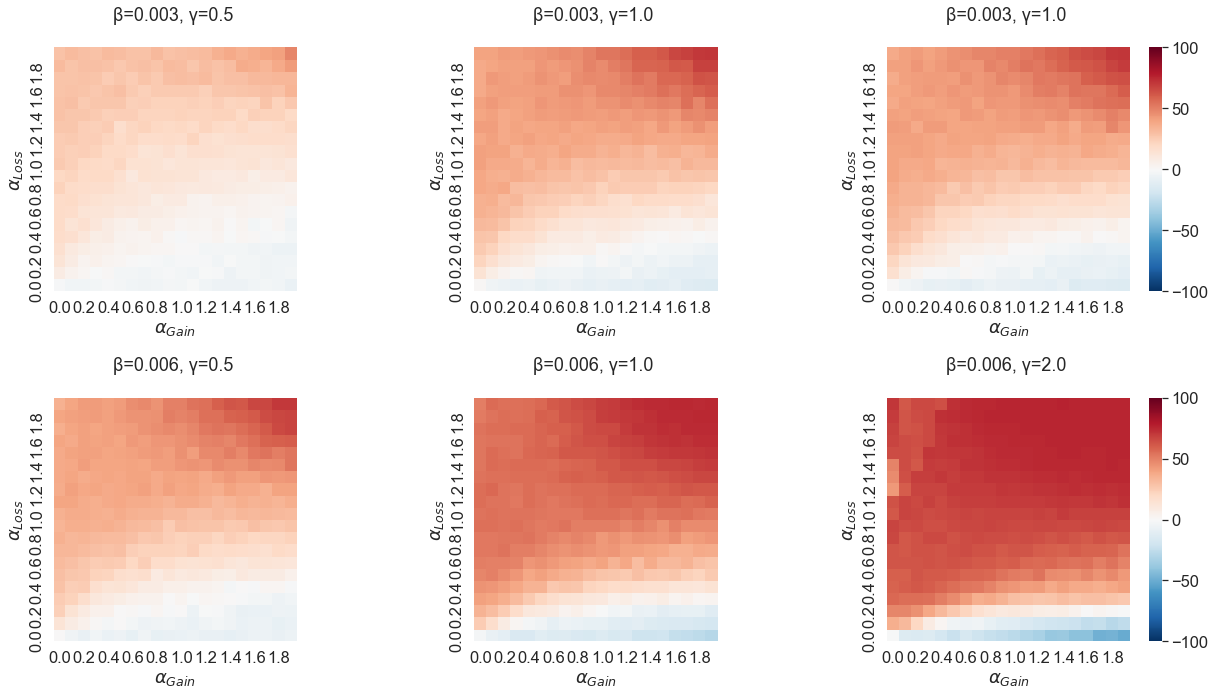

In [16]:
sns.set_theme()
sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(2,3, figsize=(18,10))
axs = axs.ravel()

for i in range(len(mydfs)):
    
    df = mydfs[i]
    curr_ax = axs[i]
    if i == 2 or i == 5: mybool = True
    else: mybool = False
    
    heatmap_df = pd.pivot(df, index = "Alpha Loss", columns = "Alpha Gain", values = "Payoff").astype('float')
    sns.heatmap(heatmap_df, square = True, cmap='RdBu_r', vmin=-100, vmax=100, xticklabels=2, cbar=mybool, 
                ax=curr_ax).invert_yaxis()
    beta = round(df["Beta"][0], 3)
    gamma = round(df["Gamma"][0], 3)
    curr_ax.set_title(f"\u03B2={beta}, \u03B3={gamma} \n")
    curr_ax.set(ylabel='$\u03B1_{Loss}$')
    curr_ax.set(xlabel='$\u03B1_{Gain}$')
    
plt.tight_layout()

## Scatter Plots
#### Defines Scatter Plots of Ratio of $\alpha_{Loss}$ to $\alpha_{Gains}$ and Payoff Scores

* Change plot_curves  to True to plot the polynomial curves of each linear regression with degrees 2-9

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

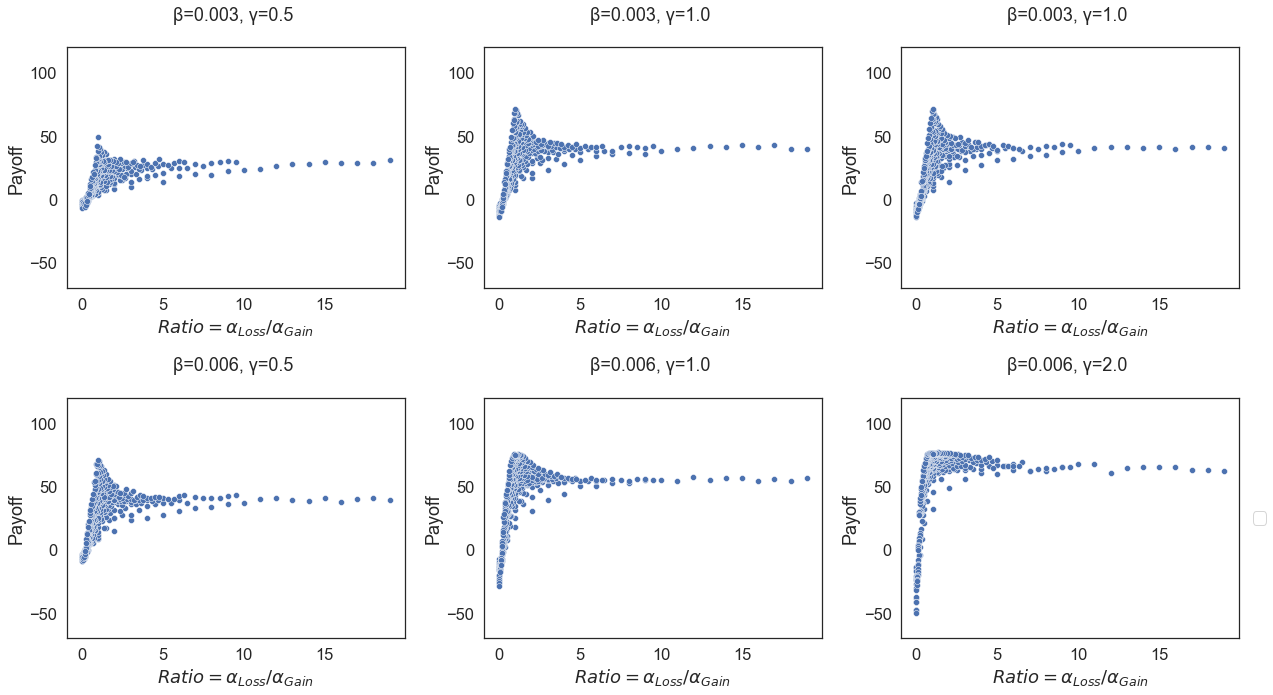

In [17]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)

plt.figure()
fig, axs = plt.subplots(2,3, figsize=(18,10))

axs = axs.ravel()

plot_curves = False

for i in range(len(mydfs)):
    
    df = mydfs[i]
    curr_ax = axs[i]
    
    df["Ratio"] = df["Alpha Loss"]/df["Alpha Gain"]
    df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index()

    scatter = sns.scatterplot(data=df, x="Ratio", y="Payoff", ax=curr_ax)
    
    beta = round(df["Beta"][0], 3)
    gamma = df["Gamma"][0]
    
    
    curr_ax.set_title(f"\u03B2={beta}, \u03B3={gamma} \n")
    curr_ax.set(xlabel='$Ratio = \u03B1_{Loss}/\u03B1_{Gain}$', ylim=(-70, 120))
    
    ratios = df["Ratio"].to_numpy()
    payoff = df["Payoff"].to_numpy()
    
    colors = ['tab:pink','tab:red', 'tab:orange', 'tab:olive', 'tab:green', 'tab:cyan', 'tab:purple', 'tab:brown']
    
    if plot_curves == True:
        for deg in range(2, 10):
            curr_color = colors[deg - 2]

            x_poly = PolynomialFeatures(degree=deg).fit_transform(ratios.reshape(-1, 1))
            lin_reg = LinearRegression()

            lin_reg.fit(x_poly, payoff.reshape(-1, 1))
            y_pred = lin_reg.predict(x_poly)

            polydf = pd.DataFrame({'Ratios': ratios, 'Y Predicted': np.concatenate(y_pred)}, 
                                  columns=['Ratios', 'Y Predicted'])
            polydf = polydf.sort_values("Ratios")

            curr_ax.plot(polydf['Ratios'], polydf['Y Predicted'], color=curr_color, label=f'degree={deg}')
        

axs[5].legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.tight_layout()

## Polynomial Linear Regression Model Fits 
#### Defines the Model Fits for Payoff vs 𝜶-Ratio (𝜶Loss/𝜶Gain)

In [18]:
model_params = []

for i in range(3, 6):
    df = mydfs[i]
    df["Ratio"] = df["Alpha Loss"]/df["Alpha Gain"]
    df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index()
    
    ratios = df["Ratio"].to_numpy()
    payoff = df["Payoff"].to_numpy()
    
    beta = round(df["Beta"][0], 3)
    gamma = df["Gamma"][0]

    for deg in range(2, 10):
        x_poly = PolynomialFeatures(degree=deg).fit_transform(ratios.reshape(-1, 1))
        model = sm.OLS(payoff, x_poly).fit()
        #lin_reg = LinearRegression()
        #lin_reg.fit(x_poly, payoff)
        
        if len(model.params) >= 4:
            model_params.append([f"{deg}", round(model.aic), 
                                           round(model.bic), 
                                           round(model.params[1], 3), 
                                           round(model.params[2], 3), 
                                           round(model.params[3], 3)])
        else:
            model_params.append([f"{deg}", round(model.aic), 
                                           round(model.bic), 
                                           round(model.params[1], 3), 
                                           round(model.params[2], 3), 
                                           "None"])

## AIC, BIC, and $\beta's$ 1, 2, and 3 for Model Fits

<Figure size 432x288 with 0 Axes>

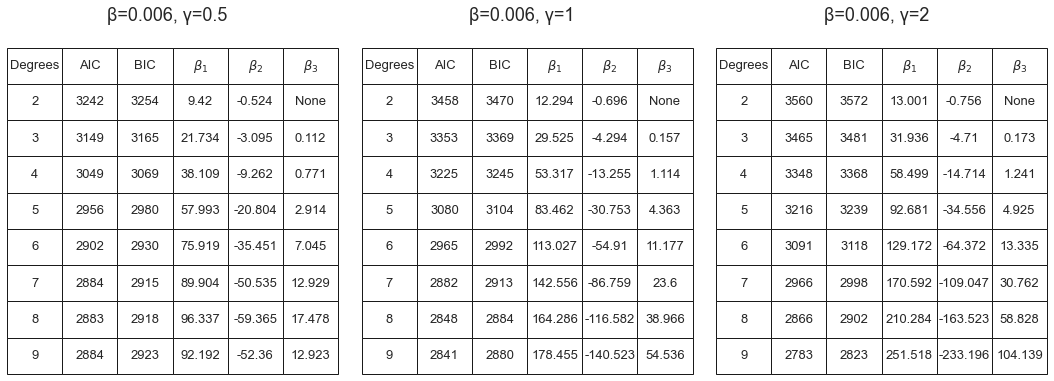

In [19]:
sns.set_theme()
sns.set_context("notebook")

plt.figure()
fig, axs = plt.subplots(1,3, figsize=(18,6))
axs = axs.ravel()

cols = ["Degrees", "AIC", "BIC", "$\u03B2_{1}$", "$\u03B2_{2}$", "$\u03B2_{3}$"]

for i in range(3):
    curr_ax = axs[i]
    curr_ax.axis('off')
    stop = 8 + (i*8)
    start = stop - 8
    gammas = [0.5, 1, 2]
    tab = curr_ax.table(model_params[start:stop], colLabels=cols ,bbox=[0, 0, 1.12, 1], cellLoc = 'center')
    curr_ax.set_title(f"      \u03B2={beta}, \u03B3={gammas[i]} \n", fontsize=18)
    tab.auto_set_font_size(False)
    tab.set_fontsize(13)